### Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model

from IPython.display import clear_output

In [2]:
tf.__version__

'2.3.0'

### MOUNT GOOGLE DRIVE

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### DECLARE GLOBAL PATH VARIABLES

In [4]:
mainFolder = '/content/drive/My Drive/Data Science Projects/Smart Building Time Series Analysis/'
datasetsPath = mainFolder + 'Datasets/'

chekpointPath = mainFolder + 'Checkpoints/'

### Custom Functions

In [5]:
def plot_corr(df):
    corr=df.corr()
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))
    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,square=True, linewidths=.5, cbar_kws={"shrink": .5})
    
def plotTimeSeriesGraph(dataframe, noOfcolumnsToPlot, setFigSize):
    values = dataframe.values
    # specify columns to plot
    #groups = [0, 1, 2, 3, 5, 6, 7]
    i = 1
    # plot each column
    plt.figure(figsize = setFigSize)
    for column in range(noOfcolumnsToPlot):
        plt.subplot(noOfcolumnsToPlot, 1, i)
        plt.plot(values[:, column])
        plt.title(dataframe.columns[column], y=0.5, loc='right')
        i += 1
    plt.show()

### Data Preprocessing

In [6]:
#dfFloor1_2018 = pd.read_csv(datasetsPath + '2018Floor1.csv', parse_dates = True, index_col = 'Date')
#dfFloor1_2019 = pd.read_csv(datasetsPath + '2019Floor1.csv', parse_dates = True, index_col = 'Date')
df = pd.read_csv(datasetsPath + '2019Floor1.csv', parse_dates = True, index_col = 'Date')
df.index.freq = 'min'

In [8]:
#CHECK FOR NAN VALUE IN THE DATA FRAME
df.isnull().sum()

z1_Light(kW)    930
z1_Plug(kW)     615
z2_AC1(kW)      811
z2_AC2(kW)      748
z2_AC3(kW)      749
z2_AC4(kW)      749
z2_Light(kW)    610
z2_Plug(kW)     694
z3_Light(kW)    599
z3_Plug(kW)     748
z4_Light(kW)    612
dtype: int64

In [9]:
# Removing NaN values from the dataset by filling appropriate values in those empty cells instead of dropping those rows.
from sklearn.impute import SimpleImputer as Im
imputer = Im(missing_values = np.nan, strategy = "mean")
#imputer_18 = imputer.fit(dfFloor1_2018.iloc[:, :])
#imputer_19 = imputer.fit(dfFloor1_2019.iloc[:, :])
#dfFloor1_2018.iloc[:, :] = imputer_18.transform(dfFloor1_2018.iloc[:, :])
#dfFloor1_2019.iloc[:, :] = imputer_19.transform(dfFloor1_2019.iloc[:, :])
im = imputer.fit(df.iloc[:, :])
df.iloc[:, :] = im.transform(df.iloc[:, :])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2019-01-01 00:00:00 to 2019-12-31 23:59:00
Freq: T
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   z1_Light(kW)  525600 non-null  float64
 1   z1_Plug(kW)   525600 non-null  float64
 2   z2_AC1(kW)    525600 non-null  float64
 3   z2_AC2(kW)    525600 non-null  float64
 4   z2_AC3(kW)    525600 non-null  float64
 5   z2_AC4(kW)    525600 non-null  float64
 6   z2_Light(kW)  525600 non-null  float64
 7   z2_Plug(kW)   525600 non-null  float64
 8   z3_Light(kW)  525600 non-null  float64
 9   z3_Plug(kW)   525600 non-null  float64
 10  z4_Light(kW)  525600 non-null  float64
dtypes: float64(11)
memory usage: 48.1 MB


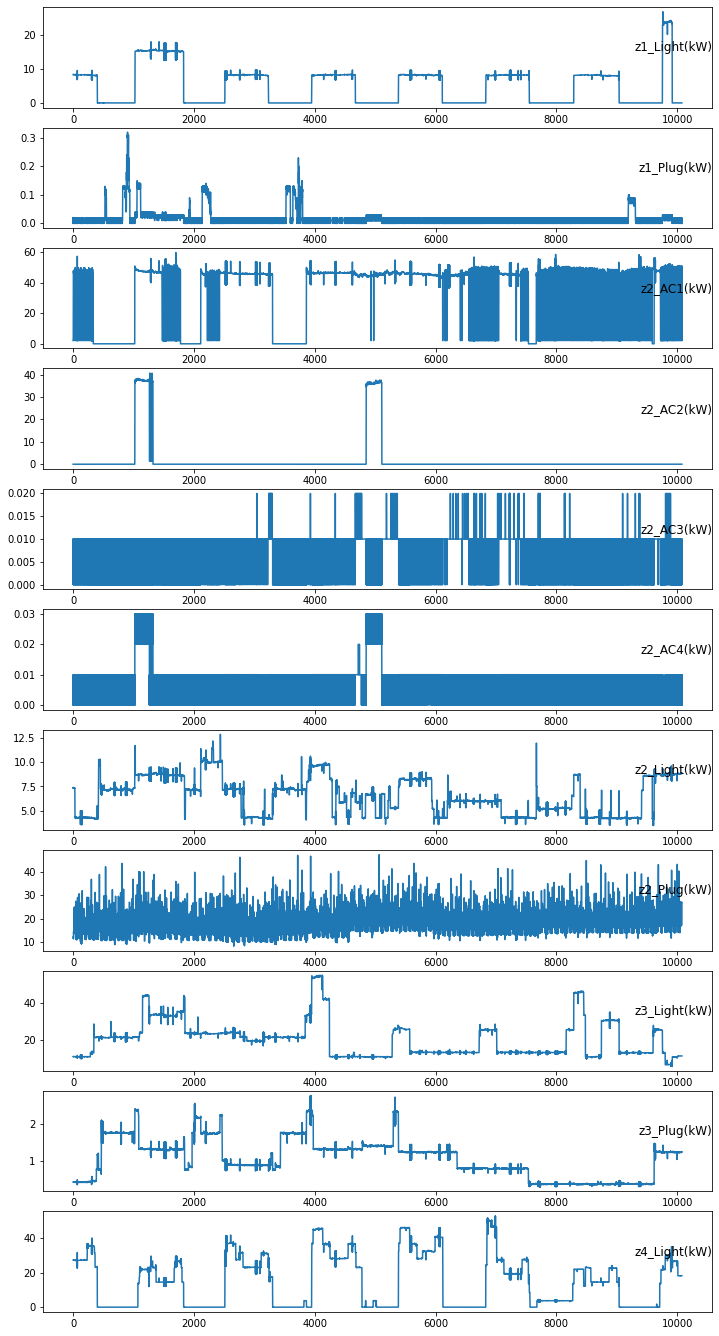

In [12]:
noOfcolumnsToPlot = 11
setFigSize = (12,24)
plotTimeSeriesGraph(df[-1440*7:], noOfcolumnsToPlot, setFigSize)

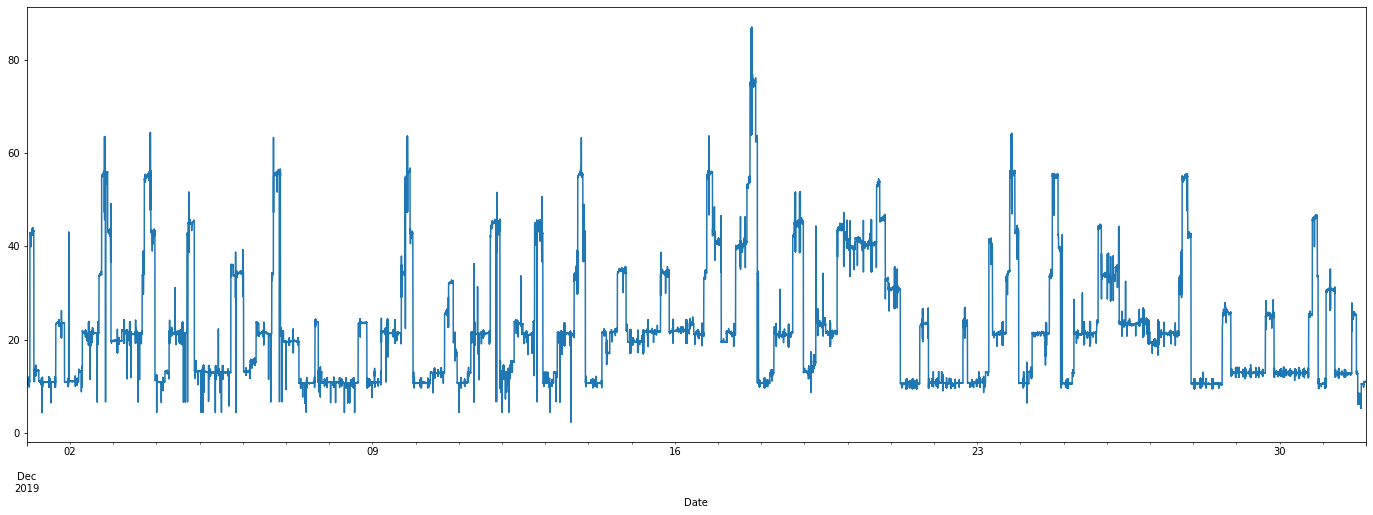

In [ ]:
df['z3_Light(kW)'].loc['2019-12-01 00:00:00':].plot(figsize=(24,8))

### Create Testing and Training Data

In [ ]:
# Keep last 30 days as test
525600 - 1440 * 30

482400

In [122]:
#SPLIT TRAINING SET AND TESTING SET
# Take the data for last 7 days intead of all 2 years to analyze the trend.
'''train = df[745920:789120]
test = df[789120:]'''
train = df[-1440*30*7:-1440*30]
test = df[-1440*30:]

In [123]:
len(train)/1440

180.0

In [124]:
len(test)/1440

30.0

## Scale Data

In [16]:
from sklearn.preprocessing import MinMaxScaler

In [125]:
scaler = MinMaxScaler()

In [126]:
# IGNORE WARNING ITS JUST CONVERTING TO FLOATS
# WE ONLY FIT TO TRAININ DATA, OTHERWISE WE ARE CHEATING ASSUMING INFO ABOUT TEST SET
scaler.fit(train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [127]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

## Generate Time Series

In [128]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
# scaled_train

In [167]:
# define generator
length = 60 # Length of the output sequences (in number of timesteps)
batch_size = 30 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=batch_size)

In [168]:
len(scaled_train)

259200

In [169]:
len(generator) 

8638

In [170]:
len(scaled_test)

43200

In [171]:
# What does the first batch look like?
X,y = generator[0]

In [172]:
X.shape

(30, 60, 11)

In [173]:
y.shape

(30, 11)

In [174]:
print(f'Given the Array: \n{X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[1.64122764e-04 2.26578765e-01 4.81599321e-01 ... 7.54107703e-02
 5.59796438e-02 2.23965544e-01]
Predict this y: 
 [[1.64122764e-04 2.23802915e-01 2.11051013e-02 8.33507853e-01
  5.00000000e-01 5.00000000e-01 2.67426273e-01 2.42161716e-01
  7.53157945e-02 5.66157761e-02 2.23811721e-01]
 [3.28245528e-04 2.25190840e-01 2.09990455e-02 8.37905759e-01
  0.00000000e+00 7.50000000e-01 2.68431635e-01 2.31298130e-01
  7.59806249e-02 5.59796438e-02 2.23965544e-01]
 [1.64122764e-04 2.24496877e-01 2.11051013e-02 8.39371728e-01
  0.00000000e+00 7.50000000e-01 2.67091153e-01 2.47112211e-01
  7.53157945e-02 5.59796438e-02 2.23811721e-01]
 [0.00000000e+00 2.23802915e-01 2.11051013e-02 8.38324607e-01
  5.00000000e-01 5.00000000e-01 2.67761394e-01 2.50825083e-01
  7.56007218e-02 5.59796438e-02 2.23657899e-01]
 [4.92368291e-04 2.23802915e-01 2.11051013e-02 8.35602094e-01
  0.00000000e+00 7.50000000e-01 2.67761394e-01 2.51512651e-01
  7.57906734e-02 5.59796438e-02 2.23657899e-01]
 [0.000

In [175]:
len(y)

30

## Create the Model

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [176]:
scaled_train.shape

(259200, 11)

In [178]:
# define model
model = Sequential()

# Simple RNN layers
model.add(LSTM(256, activation = 'relu', input_shape=(length,scaled_train.shape[1]), dropout=0.5))
#model.add(LSTM(256, return_sequences=True, dropout=0.5))
#model.add(LSTM(128, return_sequences=True, dropout=0.5))
# Final Prediction (one neuron per feature)
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [179]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_14 (LSTM)               (None, 256)               274432    
_________________________________________________________________
dense_8 (Dense)              (None, 11)                2827      
Total params: 277,259
Trainable params: 277,259
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping And Callbacks

In [164]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

filepath= chekpointPath + "TimeSeriesAnalysisModel-{epoch:02d}-{val_loss:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss',patience=3)
validation_generator = TimeseriesGenerator(scaled_test,scaled_test, length=length, batch_size=batch_size)

In [180]:
model.fit(generator, epochs=10, steps_per_epoch = 100, validation_data=validation_generator,callbacks=[early_stop,checkpoint])

Epoch 1/10
100/100 [==============================] - ETA: 0s - loss: 0.0219
Epoch 00001: val_loss improved from inf to 0.01470, saving model to /content/drive/My Drive/Data Science Projects/Smart Building Time Series Analysis/Checkpoints/TimeSeriesAnalysisModel-01-0.01.hdf5
100/100 [==============================] - 43s 428ms/step - loss: 0.0219 - val_loss: 0.0147
Epoch 2/10
100/100 [==============================] - ETA: 0s - loss: 0.0153
Epoch 00002: val_loss improved from 0.01470 to 0.01086, saving model to /content/drive/My Drive/Data Science Projects/Smart Building Time Series Analysis/Checkpoints/TimeSeriesAnalysisModel-02-0.01.hdf5
100/100 [==============================] - 42s 424ms/step - loss: 0.0153 - val_loss: 0.0109
Epoch 3/10
100/100 [==============================] - ETA: 0s - loss: 0.0134
Epoch 00003: val_loss did not improve from 0.01086
100/100 [==============================] - 42s 425ms/step - loss: 0.0134 - val_loss: 0.0109
Epoch 4/10
100/100 [====================

In [181]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

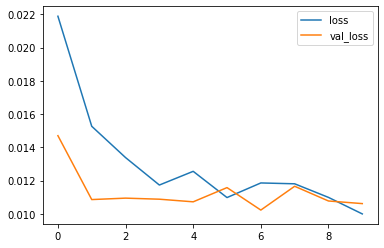

In [182]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [183]:
model.save(mainFolder+'LSTMModel_mse_0.0102.hdf5')

## Evaluate on Test Data

In [184]:
first_eval_batch = scaled_train[-length:]

In [185]:
first_eval_batch.shape

(60, 11)

In [186]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [187]:
model.predict(first_eval_batch)

array([[0.15437591, 0.0252046 , 0.29986018, 0.00325115, 0.35570252,
        0.08085425, 0.17940766, 0.21874312, 0.0928468 , 0.0361759 ,
        0.3019536 ]], dtype=float32)

In [188]:
scaled_test[0]

array([1.65763991e-01, 0.00000000e+00, 4.92523067e-01, 4.18848168e-04,
       5.00000000e-01, 2.50000000e-01, 1.80630027e-01, 3.27007701e-01,
       1.01529110e-01, 3.49872774e-02, 3.07798800e-01])

In [189]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [190]:
test_predictions

[array([0.15437591, 0.0252046 , 0.29986018, 0.00325115, 0.35570252,
        0.08085425, 0.17940766, 0.21874312, 0.0928468 , 0.0361759 ,
        0.3019536 ], dtype=float32),
 array([1.53294235e-01, 2.71315873e-02, 2.95966625e-01, 1.12200156e-04,
        3.54237348e-01, 8.13007727e-02, 1.77376449e-01, 2.13391647e-01,
        9.08883363e-02, 3.56651098e-02, 3.00195307e-01], dtype=float32),
 array([ 0.15240486,  0.02905074,  0.29335746, -0.00159265,  0.35114968,
         0.08060037,  0.17477308,  0.20880161,  0.08934574,  0.03463983,
         0.29866734], dtype=float32),
 array([ 0.151636  ,  0.03098192,  0.29112282, -0.00303764,  0.34844   ,
         0.07977122,  0.17249717,  0.20472248,  0.08791284,  0.03379318,
         0.2973793 ], dtype=float32),
 array([ 0.15098622,  0.03289573,  0.2891547 , -0.0042351 ,  0.34605372,
         0.07886516,  0.17050827,  0.20112313,  0.08657783,  0.03311667,
         0.29629228], dtype=float32),
 array([ 0.15044838,  0.0347937 ,  0.28741524, -0.0052232 

In [191]:
scaled_test

array([[1.65763991e-01, 0.00000000e+00, 4.92523067e-01, ...,
        1.01529110e-01, 3.49872774e-02, 3.07798800e-01],
       [1.66092237e-01, 6.93962526e-04, 4.98568247e-01, ...,
        1.01529110e-01, 3.43511450e-02, 3.07644978e-01],
       [1.65928114e-01, 0.00000000e+00, 4.71630077e-01, ...,
        1.01244183e-01, 3.49872774e-02, 3.08414090e-01],
       ...,
       [1.64122764e-04, 3.46981263e-04, 5.43005621e-01, ...,
        1.01149207e-01, 7.88804071e-02, 2.81495155e-01],
       [1.64122764e-04, 3.46981263e-04, 4.28253261e-01, ...,
        1.01149207e-01, 7.95165394e-02, 2.81187510e-01],
       [1.64122764e-04, 0.00000000e+00, 2.36504401e-02, ...,
        1.00864280e-01, 8.01526718e-02, 2.81495155e-01]])

## Inverse Transformations and Compare

In [192]:
true_predictions = scaler.inverse_transform(test_predictions)

In [193]:
true_predictions

array([[ 9.40612424,  0.72639665, 28.27381632, ..., 10.15583914,
         0.56868508, 19.63000443],
       [ 9.34021777,  0.78193235, 27.90669309, ...,  9.94963293,
         0.56065553, 19.51569688],
       [ 9.2860281 ,  0.83724226, 27.66067506, ...,  9.78721278,
         0.54453815, 19.41636387],
       ...,
       [11.49151626,  3.09333955, 25.80933664, ...,  6.40549993,
         0.42807496, 20.68671042],
       [11.49151626,  3.09333934, 25.80933664, ...,  6.40549993,
         0.42807502, 20.68671042],
       [11.49151626,  3.09333934, 25.80933664, ...,  6.40549914,
         0.42807496, 20.68670848]])

In [194]:
test

,z1_Light(kW),z1_Plug(kW),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),z2_Light(kW),z2_Plug(kW),z3_Light(kW),z3_Plug(kW),z4_Light(kW)
Date,,,,,,,,,,,
2019-12-02 00:00:00,10.10,0.00,46.44,0.02,0.01,0.01,5.39,24.74,11.07,0.55,20.01
2019-12-02 00:01:00,10.12,0.02,47.01,0.02,0.01,0.00,5.41,24.64,11.07,0.54,20.00
2019-12-02 00:02:00,10.11,0.00,44.47,0.02,0.02,0.01,5.39,17.53,11.04,0.55,20.05
2019-12-02 00:03:00,10.11,0.01,2.18,0.02,0.00,0.00,5.40,14.77,11.07,0.55,19.99
2019-12-02 00:04:00,10.10,0.02,2.18,0.03,0.01,0.00,5.40,14.36,11.09,0.54,20.01
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:55:00,0.02,0.01,2.22,0.03,0.00,0.01,8.85,27.00,10.98,1.25,18.28
2019-12-31 23:56:00,0.02,0.02,13.14,0.02,0.01,0.00,8.86,27.15,10.98,1.25,18.27
2019-12-31 23:57:00,0.01,0.01,51.20,0.03,0.01,0.01,8.90,20.62,11.03,1.24,18.30


In [196]:
idx = pd.date_range(start='2019-12-02 00:00:00',end='2019-12-31 23:59:00', freq='min', name='Date')
truePredictionsDf = pd.DataFrame(data=true_predictions, index=idx, columns=test.columns)

In [197]:
truePredictionsDf

,z1_Light(kW),z1_Plug(kW),z2_AC1(kW),z2_AC2(kW),z2_AC3(kW),z2_AC4(kW),z2_Light(kW),z2_Plug(kW),z3_Light(kW),z3_Plug(kW),z4_Light(kW)
Date,,,,,,,,,,,
2019-12-02 00:00:00,9.406124,0.726397,28.273816,0.155242,0.007114,0.003234,5.353524,16.866999,10.155839,0.568685,19.630004
2019-12-02 00:01:00,9.340218,0.781932,27.906693,0.005358,0.007085,0.003252,5.292913,16.477841,9.949633,0.560656,19.515697
2019-12-02 00:02:00,9.286028,0.837242,27.660675,-0.076049,0.007023,0.003224,5.215229,16.144053,9.787213,0.544538,19.416364
2019-12-02 00:03:00,9.239182,0.892899,27.449971,-0.145047,0.006969,0.003191,5.147315,15.847419,9.636342,0.531229,19.332629
2019-12-02 00:04:00,9.199591,0.948055,27.264397,-0.202226,0.006921,0.003155,5.087967,15.585674,9.495779,0.520594,19.261961
...,...,...,...,...,...,...,...,...,...,...,...
2019-12-31 23:55:00,11.491516,3.093339,25.809337,-0.406165,0.006939,0.002125,4.667299,13.502830,6.405501,0.428075,20.686710
2019-12-31 23:56:00,11.491516,3.093339,25.809337,-0.406164,0.006939,0.002125,4.667299,13.502830,6.405500,0.428075,20.686708
2019-12-31 23:57:00,11.491516,3.093340,25.809337,-0.406165,0.006939,0.002125,4.667299,13.502830,6.405500,0.428075,20.686710


In [198]:
truePredictionsDf.to_csv(mainFolder+'LSTMPredictionFor30Days.csv')

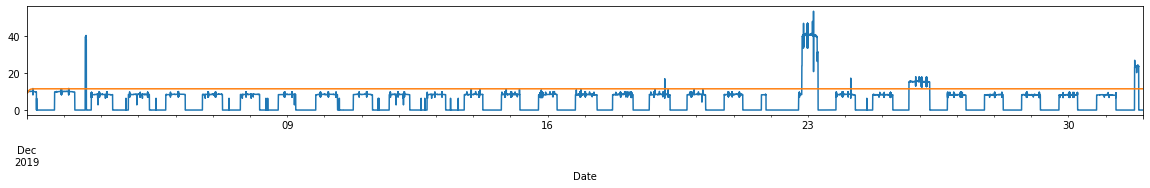

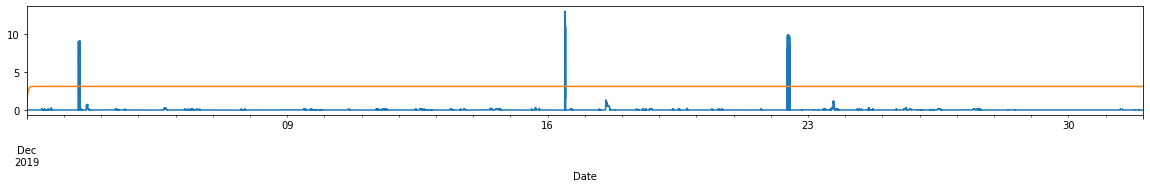

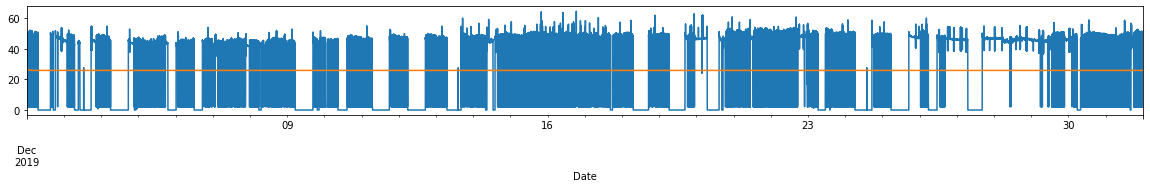

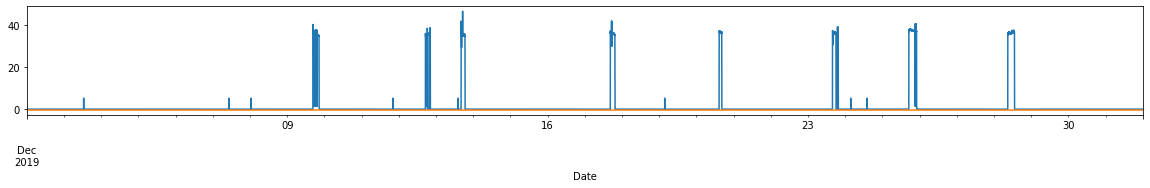

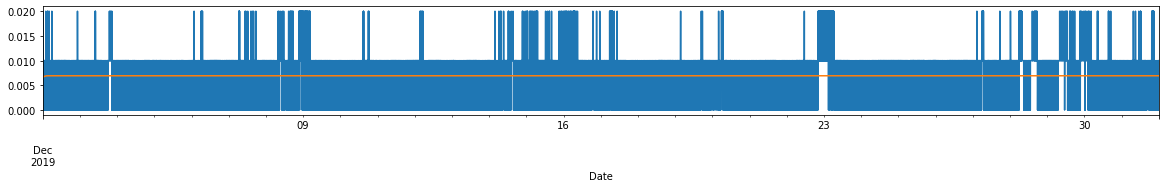

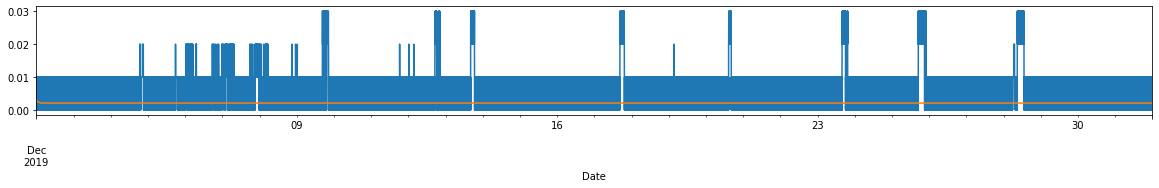

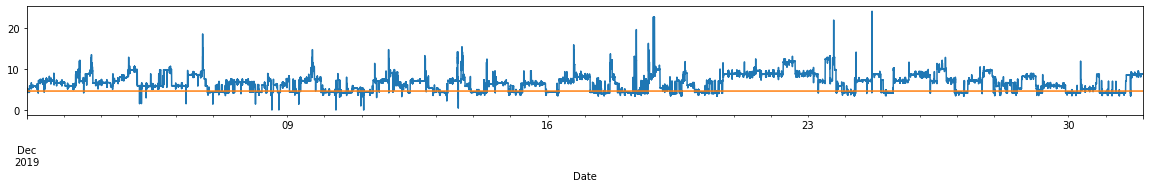

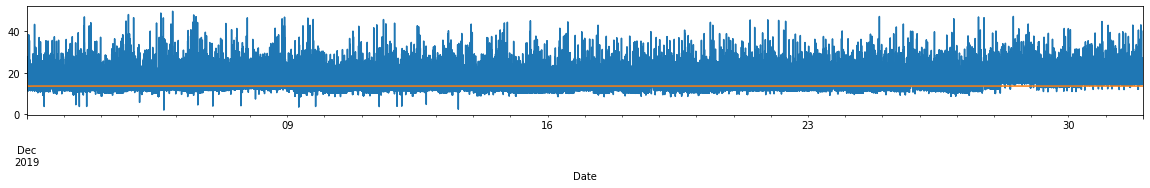

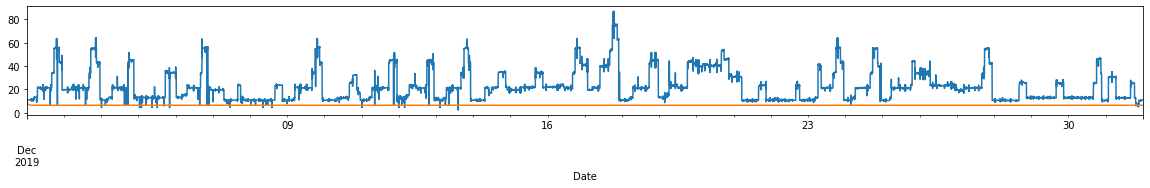

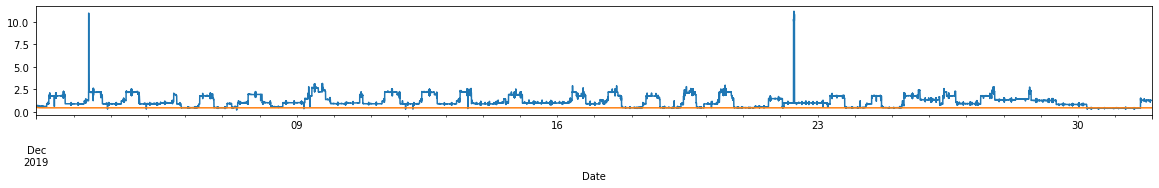

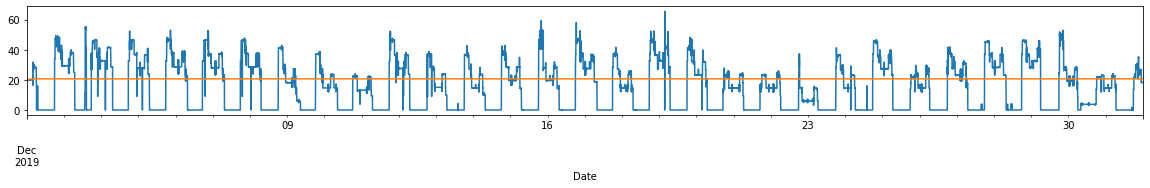

In [199]:
dfCols = test.columns.to_list()
for col in dfCols:
  test[col].plot(figsize=(20,2)).autoscale(axis='x',tight=True)
  truePredictionsDf[col].plot(figsize=(20,2))
  plt.show();

## RMSE

In [200]:
from statsmodels.tools.eval_measures import rmse

In [119]:
for col in dfCols:
  RMSE = rmse(test[col], truePredictionsDf[col])
  print(f'For Column {col} LSTM RMSE: {RMSE:.3f}')

For Column z1_Light(kW) LSTM RMSE: 7.625
For Column z1_Plug(kW) LSTM RMSE: 0.028
For Column z2_AC1(kW) LSTM RMSE: 20.872
For Column z2_AC2(kW) LSTM RMSE: 0.398
For Column z2_AC3(kW) LSTM RMSE: 0.005
For Column z2_AC4(kW) LSTM RMSE: 0.005
For Column z2_Light(kW) LSTM RMSE: 2.908
For Column z2_Plug(kW) LSTM RMSE: 6.358
For Column z3_Light(kW) LSTM RMSE: 10.500
For Column z3_Plug(kW) LSTM RMSE: 0.406
For Column z4_Light(kW) LSTM RMSE: 13.070


In [202]:
for col in dfCols:
  RMSE = rmse(test[col], truePredictionsDf[col])
  print(f'For Column {col} LSTM RMSE: {RMSE:.3f}')

For Column z1_Light(kW) LSTM RMSE: 9.074
For Column z1_Plug(kW) LSTM RMSE: 3.073
For Column z2_AC1(kW) LSTM RMSE: 21.872
For Column z2_AC2(kW) LSTM RMSE: 6.652
For Column z2_AC3(kW) LSTM RMSE: 0.005
For Column z2_AC4(kW) LSTM RMSE: 0.007
For Column z2_Light(kW) LSTM RMSE: 2.832
For Column z2_Plug(kW) LSTM RMSE: 5.487
For Column z3_Light(kW) LSTM RMSE: 20.704
For Column z3_Plug(kW) LSTM RMSE: 0.954
For Column z4_Light(kW) LSTM RMSE: 16.573
